# Stock Market
The stock market is a marketplace that allows for the seamless exchange of corporate stock purchases and sales. Every Stock Exchange has its own value for the Stock Index. The index is the average value derived by adding up the prices of various equities. This aids in the representation of the entire stock market as well as the forecasting of market movement over time. The stock market can have a significant impact on individuals and the economy as a whole. As a result, effectively predicting stock trends can reduce the risk of loss while increasing profit.


We will use the ARIMA model to forecast the stock price of RELIANCE INDUSTRIES.

## ARIMA
Before working with non-stationary data, the Autoregressive Integrated Moving Average (ARIMA) Model converts it to stationary data. One of the most widely used models for predicting linear time series data is this one.

The ARIMA model has been widely utilized in banking and economics since it is recognized to be reliable, efficient, and capable of predicting short-term share market movements.

### Load required libraries

In [10]:
!pip install pmdarima

In [48]:
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import math
import yfinance as yf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [12]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

stock_data = yf.download("RELIANCE.NS", start="2020-01-01", end="2023-02-03")
stock_data = stock_data.round(2)

[*********************100%***********************]  1 of 1 completed


In [13]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,1503.75,1512.76,1491.36,1495.42,1480.60,6463060
2020-01-02,1497.80,1526.48,1497.80,1520.88,1505.80,8173308
2020-01-03,1518.61,1527.17,1508.70,1522.72,1507.62,9684434
2020-01-06,1505.73,1513.55,1483.93,1487.40,1472.65,11315596
2020-01-07,1504.74,1520.09,1499.29,1510.28,1495.31,7699489
...,...,...,...,...,...,...
2023-01-27,2384.40,2387.35,2311.65,2337.35,2337.35,11920991
2023-01-30,2331.70,2371.90,2301.00,2359.75,2359.75,10047822
2023-01-31,2382.00,2387.65,2341.00,2353.85,2353.85,10472167


### Visualize the stock’s daily closing price.

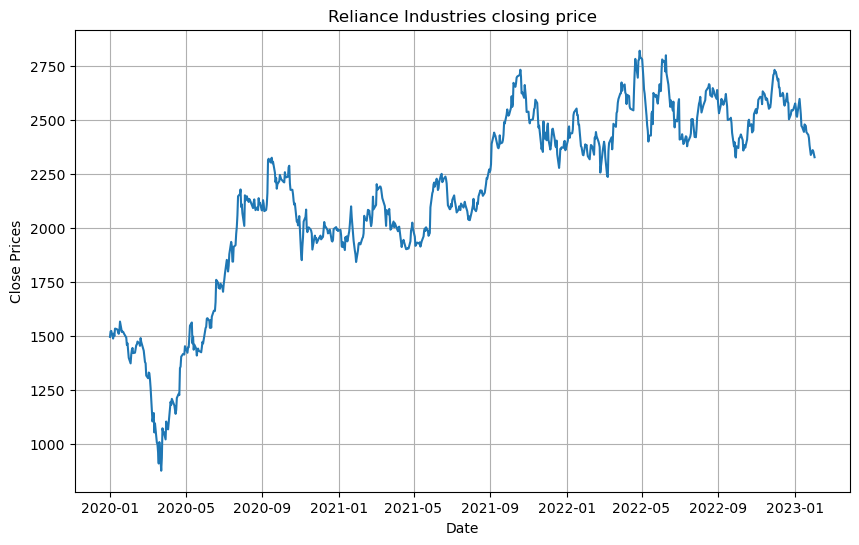

In [14]:
#plot close price

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('Reliance Industries closing price')
plt.show()

### Plotting probability distribution

<AxesSubplot:ylabel='Density'>

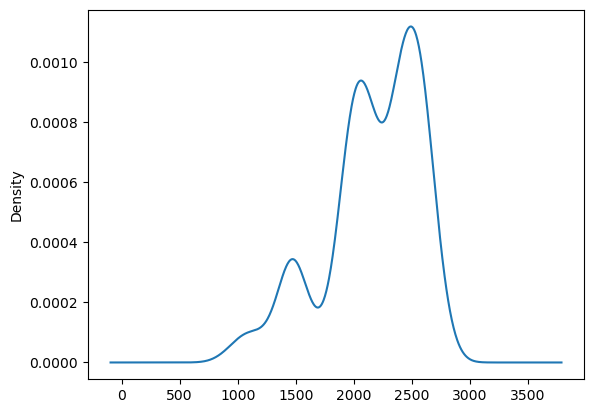

In [15]:
#Distribution of the dataset

df_close = stock_data['Close']
df_close.plot(kind='kde')

#### A time series is also regarded to include three systematic components: level, trend, and seasonality, as well as one non-systematic component termed noise.

The following are the components’ definitions:

1. The average value in the series is called the level.
2. The increasing or falling value in the series is referred to as the trend.
3. Seasonality is the series’ recurring short-term cycle.
4. The random variance in the series is referred to as noise.


Because time series analysis only works with stationary data, we must first determine whether a series is stationary.

### ADF (Augmented Dickey-Fuller) Test
One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:

**Null Hypothesis:** The series has a unit root (value of a =1)

**Alternate Hypothesis:** The series has no unit root.

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

The series becomes stationary if both the mean and standard deviation are flat lines (**constant mean and constant variance**).

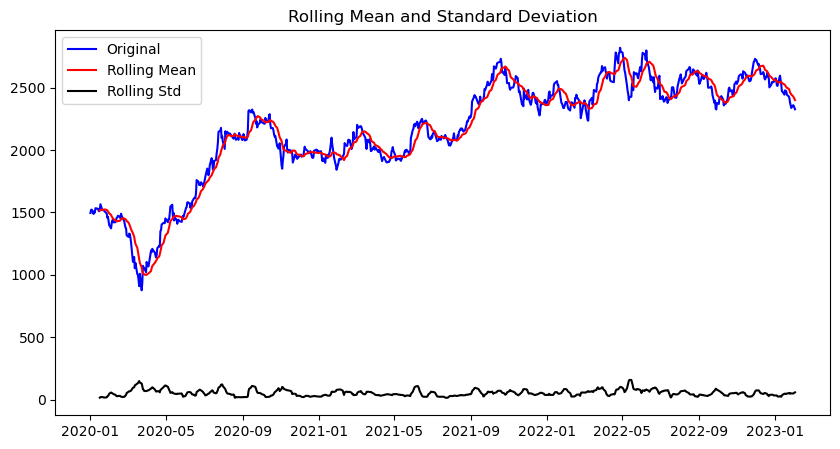

Results of dickey fuller test
Test Statistics                 -1.801952
p-value                          0.379493
No. of lags used                 0.000000
Number of observations used    769.000000
critical value (1%)             -3.438882
critical value (5%)             -2.865306
critical value (10%)            -2.568775
dtype: float64


In [39]:
#Test for staionarity

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # Setting the weidth and height
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(5)
    
    #Plot rolling statistics:
    
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)


The increasing mean and standard deviation may be seen in the graph above, indicating that our series isn’t stationary.

We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear.

Seasonality and trend may need to be separated from our series before we can undertake a time series analysis. This approach will cause the resulting series to become stagnant.

### Let’s isolate the time series from the Trend and Seasonality.

<Figure size 640x480 with 0 Axes>

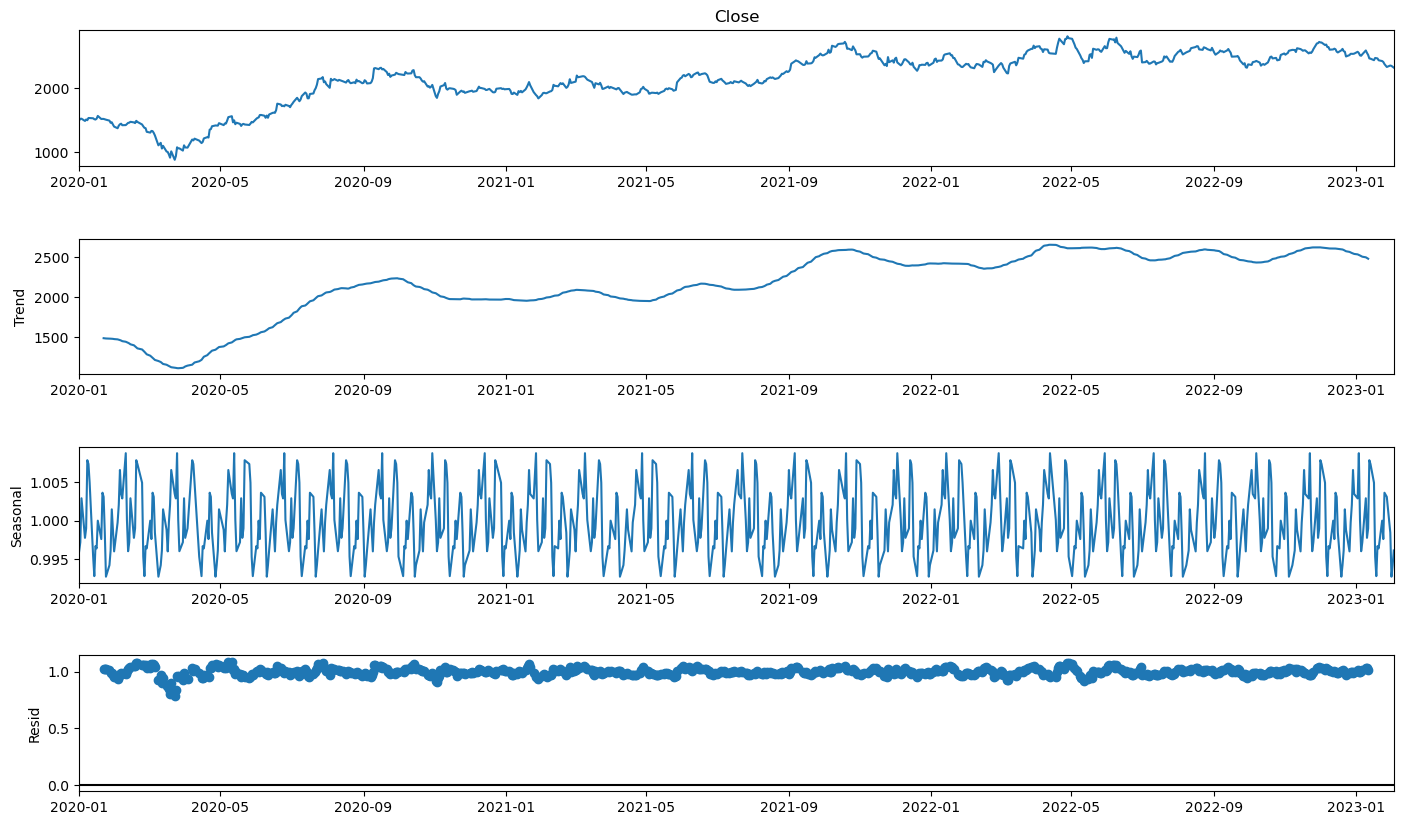

In [41]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.

result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

To reduce the magnitude of the values and the growing trend in the series, we first take a log of the series. We then calculate the rolling average of the series after obtaining the log of the series. A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


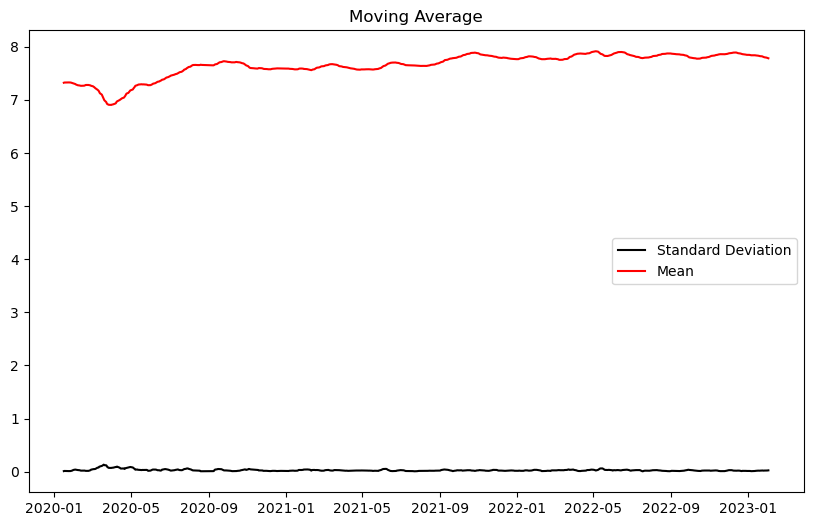

In [44]:
#if not stationary then eliminate trend

#Eliminate trend
from pylab import rcParams

rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we’ll develop an ARIMA model and train it using the stock’s closing price from the train data. So, let’s visualize the data by dividing it into training and test sets.

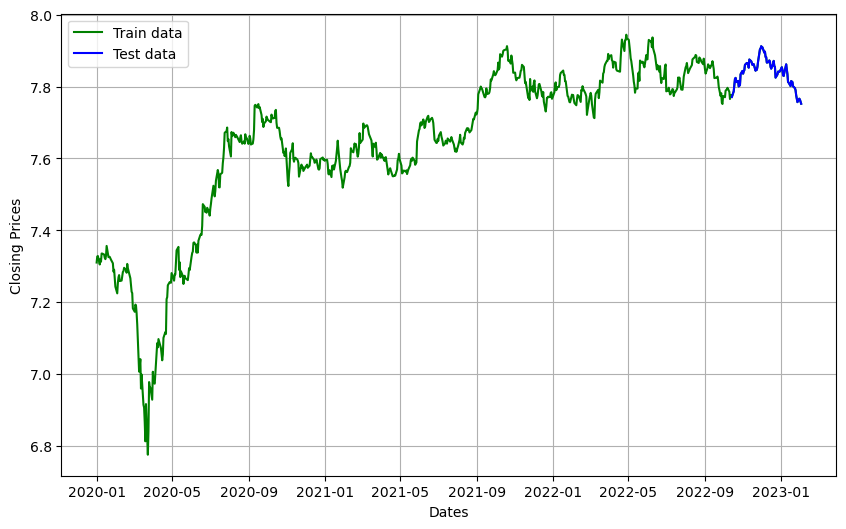

In [45]:
#split data into train and training set

train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

It’s time to choose the ARIMA model’s p,q, and d parameters. We chose the values of p,d, and q last time by looking at the ACF and PACF charts, but this time we’ll utilize Auto ARIMA to find the best parameters without looking at the ACF and PACF graphs.

#### Auto ARIMA: Automatically discover the optimal order for an ARIMA model.
The auto_arima function returns a fitted ARIMA model after determining the most optimal parameters for an ARIMA model. This function is based on the **forecast::auto. Arima** R function, which is widely used.

The auro_arima function works by performing differencing tests (e.g., **Augmented Dickey-Fuller**) to determine the order of differencing, d, and then fitting models within start p, max p, start q, max q ranges. After conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D, auto_arima also seeks to identify the optimal P and Q hyper-parameters if the seasonal option is enabled.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3280.894, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3282.533, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3282.256, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3282.247, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3281.467, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3280.935, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3279.739, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3283.789, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3282.774, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3282.198, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3283.513, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3281.133, Time=0.40 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.083 seconds
                               SARIMAX Results                              

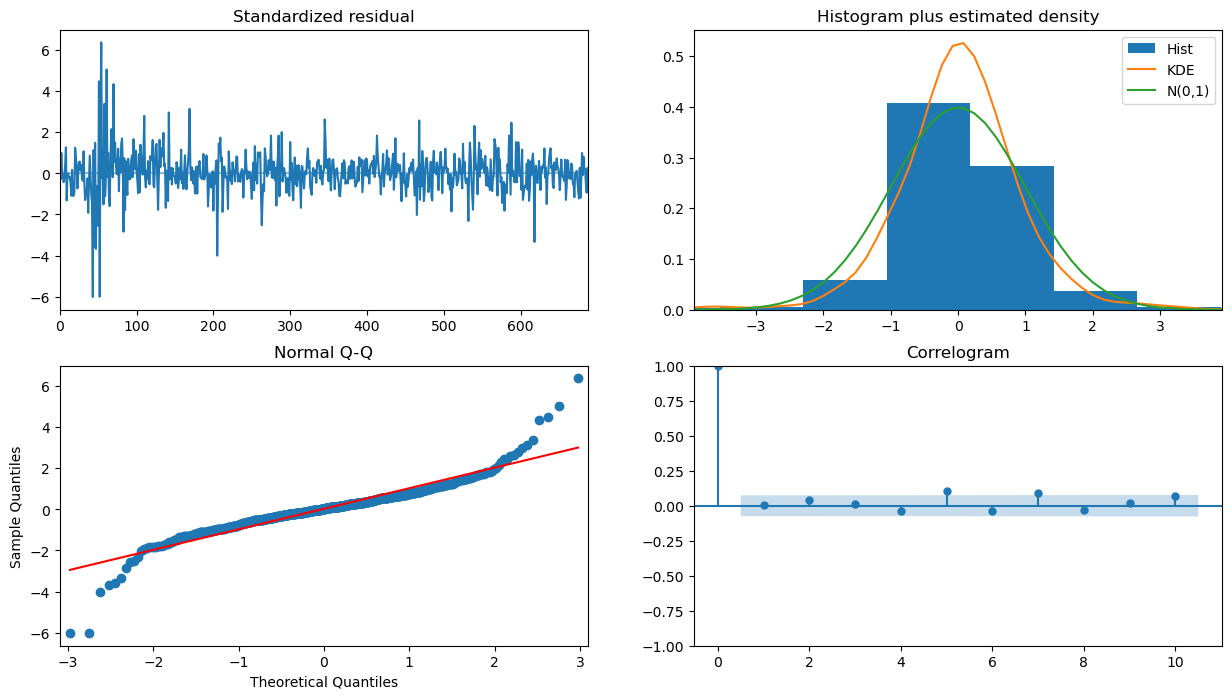

In [46]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Above plots are interpreted as: 
**Standardized residual(Top left)**: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

**Histogram Plus Estimated Density(Top Right)**: The density plot on the top right suggests a normal distribution with a mean of zero.

**Q-Q Plot(Bottom left)**: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

**Correlogram(Bottom Right)**: The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

**As a result, the Auto ARIMA model assigned the values 1, 1, and 2 to, p, d, and q, respectively.**

In [50]:
#Modeling
# Build Model

import statsmodels.api as smapi

model = smapi.tsa.arima.ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  690
Model:                 ARIMA(1, 1, 2)   Log Likelihood                1644.464
Date:                Wed, 15 Mar 2023   AIC                          -3280.929
Time:                        20:28:50   BIC                          -3262.788
Sample:                             0   HQIC                         -3273.911
                                - 690                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0347      0.582     -0.060      0.953      -1.176       1.107
ma.L1         -0.0347      0.586     -0.059      0.953      -1.183       1.113
ma.L2          0.0440      0.051      0.859      0.3

### Let’s now begin forecasting stock prices on the test dataset with a 95% confidence level.

In [ ]:
# Forecast

fc = fitted.forecast(321, alpha=0.05)  # 95% conf

# Make as pandas series

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)

plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Our model played great, as you can see. Let’s take a look at some of the most common accuracy metrics for evaluating forecast results:

In [ ]:
# report performance

mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

In [ ]:
## With a MAPE of around 2.5%, the model is 97.5% accurate in predicting the next 15 observations.